# Geographic collaboration network for EMBL-EBI services literature
Our challenge this afternoon is to generate the data consumed by [this data visualisation](https://observablehq.com/@ficolo/infrafrontier-collaboration-network), using one of the provided datasets. The visualisation is a network representation of the collaboration among institutions in different geographic locations that publish scientific papers using EBI services. The circles represent institutions that have published papers using some of our resoruces, the radius is computed using the publication count for each institution and the egdes between the circles represent at least one shared paper between the linked institutions.

## Target data structure

For power up our collaboration network map, we need an array of nodes and an array of links. A nodes should look like this:


```Python
{
  "count": 17,
  "id": "bf5bddac1843fb75cdb4dccf8ed4af67",
  "lat": "48.857",
  "long": "2.351",
  "name": "Institut National de la Sante et de la Recherche Medicale U515"
}
```
Where count is the number of references produced in the specified location and id is a hash of the concatenation of the latitude and longitued.

And a link should look like this:

```Python
{
  "src": "bf5bddac1843fb75cdb4dccf8ed4af67",
  "tgt": "e3219afe5a918ca9d0555355dda7a4da"
}
```

Where source and target are linked node's ids.

## Download the data
Create a ```data``` directory and uncompress the zip file available [here](https://wwwdev.ebi.ac.uk/~federico/spark-session-1-data.zip).

## Using [findspark](https://github.com/minrk/findspark) to locate you Apache Spark installation and load PySpark

In [1]:
import findspark
findspark.init()

## Creating a Spark Session

In [2]:
from pyspark.sql import SparkSession

In [3]:
spark = SparkSession.builder.appName("EBICollaborationNetworkGenerator").getOrCreate()

Check [http://localhost:4040/jobs/](http://localhost:4040/jobs/) to see your Spark local session web interface.

## Let's select a dataset

Available datasets:

```Python
{"name": "mousephenotype.org", "primaryColor": "#17a2b8", "secondaryColor": "#b65a14"}
{"name": "chembl", "primaryColor": "#06979b", "secondaryColor": "#d33c60"}
{"name": "interpro", "primaryColor": "#0160a3", "secondaryColor": "#abd6ba"}
{"name": "pdbe", "primaryColor": "#659966", "secondaryColor": "#e44848"}
{"name": "pdx_finder", "primaryColor": "#04369d", "secondaryColor": "#01b2d5"}
```

In [4]:
dataset = {"name": "mousephenotype.org", "primaryColor": "#17a2b8", "secondaryColor": "#b65a14"}

## Load the MapAffil dataset
To load your data from the file system to a Spark DataFrame you can use the [Generic Load/Save Functions](https://spark.apache.org/docs/latest/sql-data-sources-load-save-functions.html) available from your ```spark``` session object. Apache Spark has included several readers by default via the ```spark.read```  interface, check [spark.read.csv()](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.csv).

****Hint***: the ```sep``` and the ```header``` parameters can be useful for this task.

In [5]:
mapaffil_df = spark.read.csv('data/mapaffil2016.tsv', sep="\t", header=True)

In [ ]:
mapaffil_df.printSchema()

In [ ]:
mapaffil_df.show(vertical=True)

## Load the service's references dataset
Just like you did with the MapAffil dataset you can use a Spark DataFrame reader from ```spark.read```to load the references json files, check [spark.read.json()](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.json).

In [6]:
references_df = spark.read.json('data/' + dataset['name'])

In [ ]:
references_df.printSchema()

In [ ]:
references_df.show(vertical=True)

## Create a _reference vs location_ DataFrame
We are going to make our first ```join```, so be prepared.

- First we should try to make both DataFrames uniform, in terms of the granularity of the data represented in every row. Let's think about the structure of our DataFrames for a minute. Our references DataFrame has one row per paper, so one PMID is only once in the DataFrame, and our MapAffil DataFrame contains a row per each pair of PMID and author, so a PMID could appear several times in the dataset. Let's try to transform our references DataFrame to match the PMID,author row structure of the MapAffil DataFrame.
****Hint:*** Check the [```withColumn```](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html?#pyspark.sql.DataFrame.withColumn) transformation and the [```explode``` ](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.explode) function.
- Then lets make the join between both DataFrames, we want to join then over the ```PMID``` and ```author.lastName``` columns. That way we can get the name of the affiliation from our references DataFrame and the latitutde and longitude from our MapAffil DataFrame.
****Hint:*** Check the [```join```](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=join#pyspark.sql.DataFrame.joinCheck) function.

In [7]:
from pyspark.sql.functions import explode

references_df = references_df.withColumn('author', explode('authorList.author'))

In [8]:
references_vs_map_df = references_df.join(
            mapaffil_df,
            (references_df.pmid == mapaffil_df.PMID) & (references_df.author.lastName == mapaffil_df.lastname)
)

## Let's make a location id
For the location id we want to [concat](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=join#pyspark.sql.functions.concat) the ```lat```and ```lon```columns and then apply a [hash](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=join#pyspark.sql.functions.md5) function over the concatenation. ****Hint:*** Check the [```withColumn```](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html?#pyspark.sql.DataFrame.withColumn) transformation.

In [9]:
from pyspark.sql.functions import concat, md5

references_vs_map_df = references_vs_map_df.withColumn('id', md5(concat(references_vs_map_df.lat, references_vs_map_df.lon)))

## Why don't we drop what we don't need
For our nodes and links we only need the id, the latitude and longitude, the affiliation name and the pmids, so let's do a select for that columns only

In [10]:
references_vs_map_df = references_vs_map_df.select(
    references_vs_map_df.id,
    mapaffil_df.lat,
    mapaffil_df.lon,
    references_df.author.affiliation.alias("name"),
    references_df.pmid)

## Let's do some grouping
In order to make the count and calculate the links we need to group our DataFrame rows by id, longitude, latitude and affiliation name. ****Hint:*** Check the [```groupBy```](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html?#pyspark.sql.DataFrame.groupby) transformation and the [```collect_set```](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html?#pyspark.sql.functions.collect_set) aggregation function.

In [11]:
from pyspark.sql.functions import collect_set, first

references_vs_map_df = references_vs_map_df.groupBy("id", "lat", "lon").agg(first("name").alias("name"), collect_set("pmid").alias("pmids"))

In [ ]:
references_vs_map_df.show()

## Let's make the count!
To add the publication count by location we only need to calculate the size of the pmids sets. ****Hint:*** Check the [size](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html?#pyspark.sql.functions.size) function.

In [12]:
from pyspark.sql.functions import size

nodes_df = references_vs_map_df.withColumn('count', size("pmids")).drop("pmids")

## Finally we have to compute our links
Let's do a self join and then let's try to compute the intesection of pmids, after that we just need to filter for those rows with a intersection with at least one element. ****Hint:*** Check the function [```array_intersect```](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html?#pyspark.sql.functions.array_intersect). Also check the [```alias```](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=alias#pyspark.sql.DataFrame.alias). Also, use the [```col```](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=alias#pyspark.sql.functions) function to access your columns this time.

In [13]:
from pyspark.sql.functions import array_intersect, col
a = references_vs_map_df.select("id", "pmids").alias("a")
b = references_vs_map_df.select("id", "pmids").alias("b")

c = a.join(b, col('a.id') != col('b.id'), 'left')
links_df = c.withColumn('degree', size(array_intersect(col('a.pmids'),col('b.pmids'))))
links_df = links_df.withColumn('src', col('a.id')).withColumn('tgt', col('b.id'))
links_df = links_df.where(links_df.src != links_df.tgt)
links_df = links_df.where(links_df.degree > 0).select('src', 'tgt')

## Let's collect and plot our data

In [14]:
nodes = nodes_df.collect()

In [15]:
links = links_df.collect()

## Now let's transform those rows to python dicts

In [16]:
nodes = [row.asDict() for row in nodes if row['lat'] != 'NULL' and row['lon'] != 'NULL']

In [17]:
links = [row.asDict() for row in links]

## Look our data!

In [18]:
from vega import Vega

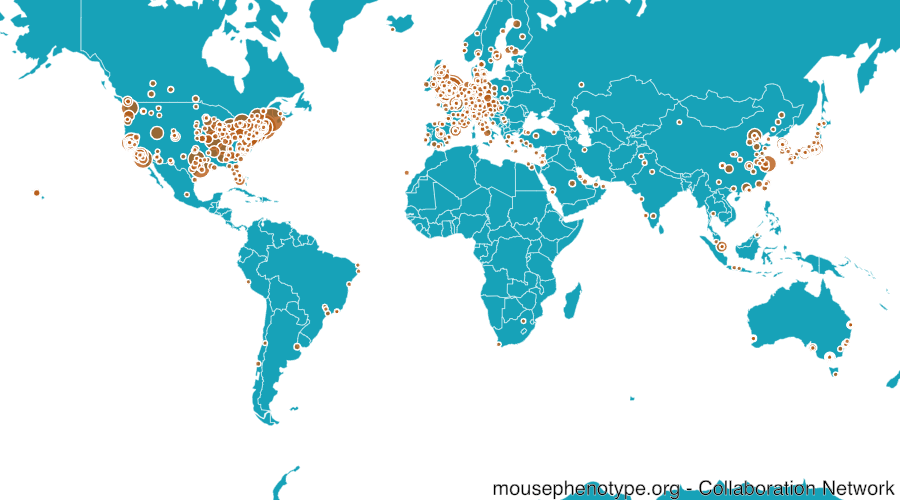

In [19]:
Vega({'$schema': 'https://vega.github.io/schema/vega/v5.json', 'width': 900, 'height': 500, 'autosize': 'none', 'signals':[{'name': 'hover', 'value': None, 'on': [{'events': '@cell:mouseover', 'update': 'datum'}, {'events': '@cell:mouseout', 'update': 'null'}]}, {'name': 'title', 'value':  dataset['name'] + ' - Collaboration Network', 'update': "hover ? hover.name : '" + dataset["name"] +" - Collaboration Network'"}, {'name': 'tx', 'update': 'width / 2'}, {'name': 'ty', 'update': 'height / 2'}, {'name': 'scale', 'value': 150, 'on': [{'events': {'type': 'wheel', 'consume': True}, 'update': 'clamp(scale * pow(1.0005, -event.deltaY * pow(16, event.deltaMode)), 150, 3000)'}]}, {'name': 'angles', 'value': [0, 0], 'on': [{'events': 'mousedown', 'update': '[rotateX, centerY]'}]}, {'name': 'cloned', 'value': None, 'on': [{'events': 'mousedown', 'update': "copy('projection')"}]}, {'name': 'start', 'value': None, 'on': [{'events': 'mousedown', 'update': 'invert(cloned, xy())'}]}, {'name': 'drag', 'value': None, 'on': [{'events': '[mousedown, window:mouseup] > window:mousemove', 'update': 'invert(cloned, xy())'}]}, {'name': 'delta', 'value': None, 'on': [{'events': {'signal': 'drag'}, 'update': '[drag[0] - start[0], start[1] - drag[1]]'}]}, {'name': 'rotateX', 'value': 0, 'on': [{'events': {'signal': 'delta'}, 'update': 'angles[0] + delta[0]'}]}, {'name': 'centerY', 'value': 0, 'on': [{'events': {'signal': 'delta'}, 'update': 'clamp(angles[1] + delta[1], -60, 60)'}]}], 'projections': [{'name': 'projection', 'type': 'mercator', 'scale': {'signal': 'scale'}, 'rotate': [{'signal': 'rotateX'}, 0, 0], 'center': [0, {'signal': 'centerY'}], 'translate': [{'signal': 'tx'}, {'signal': 'ty'}]}], 'data': [{'name': 'world', 'url': 'https://raw.githubusercontent.com/vega/vega/master/docs/data/world-110m.json', 'format': {'type': 'topojson', 'feature': 'countries'}}, {'name': 'nodes', 'transform': [{'type': 'geopoint', 'projection': 'projection', 'fields': ['lon', 'lat']}, {'type': 'voronoi', 'x': 'x', 'y': 'y'}, {'type': 'collect', 'sort': {'field': 'count', 'order': 'descending'}}], 'values': nodes}, {'name': 'links', 'transform': [{'type': 'filter', 'expr': 'hover && (hover.id == datum.src || hover.id == datum.tgt)'}, {'type': 'lookup', 'from': 'nodes', 'key': 'id', 'fields': ['src', 'tgt'], 'as': ['source', 'target']}, {'type': 'filter', 'expr': 'datum.source && datum.target'}, {'type': 'linkpath', 'shape': 'curve'}], 'values': links}], 'scales': [{'name': 'size', 'type': 'linear', 'domain': {'data': 'nodes', 'field': 'count'}, 'range': [16, 1000]}], 'marks': [{'type': 'shape', 'from': {'data': 'world'}, 'encode': {'enter': {'strokeWidth': {'value': 0.5}, 'stroke': {'value': '#FFF'}, 'fill': {'value': dataset["primaryColor"]}}}, 'transform': [{'type': 'geoshape', 'projection': 'projection'}]}, {'type': 'symbol', 'from': {'data': 'nodes'}, 'encode': {'enter': {'size': {'scale': 'size', 'field': 'count'}, 'fill': {'value': dataset["secondaryColor"]}, 'fillOpacity': {'value': 0.8}, 'stroke': {'value': 'white'}, 'strokeWidth': {'value': 1.5}}, 'update': {'x': {'field': 'x'}, 'y': {'field': 'y'}}}}, {'type': 'path', 'name': 'cell', 'from': {'data': 'nodes'}, 'encode': {'enter': {'fill': {'value': 'transparent'}}, 'update': {'path': {'field': 'path'}}}}, {'type': 'path', 'interactive': False, 'from': {'data': 'links'}, 'encode': {'enter': {'path': {'field': 'path'}, 'stroke': {'value': 'black'}, 'strokeOpacity': {'value': 0.15}}}}, {'type': 'text', 'interactive': False, 'encode': {'enter': {'x': {'signal': 'width', 'offset': -5}, 'y': {'signal': 'height', 'offset': -5}, 'fill': {'value': 'black'}, 'fontSize': {'value': 20}, 'align': {'value': 'right'}, 'stroke': {'value': 'white'}, 'strokeWidth': {'value': 0.5}}, 'update': {'text': {'signal': 'title'}}}}]})